# DCGAN 실습

## 모듈 임포트

In [13]:
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### CNN 사이즈 계산기 정의

In [6]:
def conv_dim(i,k,s,p):
    '''
    nn.Conv2d 사용할 때 사이즈 계산
    i: input image size
    k: kernel size
    s: stride
    p: padding
    '''
    out = (i - k + 2*p)/s + 1
    return out  

In [8]:
def convt_dim(i,k,s,p):
    '''
    nn.ConvTranspose2d 사용할 때 사이즈 계산
    i: input image size
    k: kernel size
    s: stride
    p: padding
    '''
    out = (i-1) * s - 2 * p + k
    return out  

## G: Generator 구현

In [67]:
class Generator(nn.Module):
    def __init__(self, z_dim = 20, image_size = 64):
        super(Generator, self).__init__()

        # layer1 -> W(H) * 4
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size = 4, stride = 1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))
        
        # layer2 -> W(H) * 2
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size= 4, stride=2, padding=1), # 흑백 이미지이므로 출력 차원을 1으로 지정한 것
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        out = out.type(torch.FloatTensor)
        return out

### 학습이 안된 G의 출력

In [15]:
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)

# tensor size -> (1, 20, 1, 1) 
# pytorch: (batch_size, channel, height, width)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_img = G(input_z)

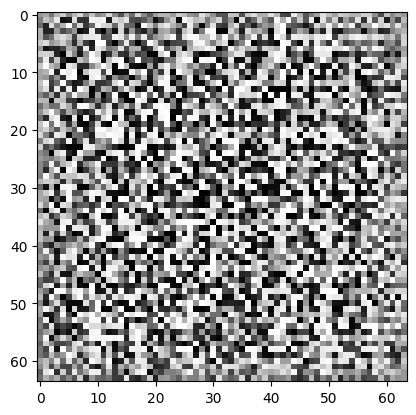

In [16]:
# fake_img[0][0].size() -> (64, 64)
img_transformed = fake_img[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

## D: Discriminator 구현

In [68]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        out = out.type(torch.FloatTensor)
        return out

In [23]:
D = Discriminator(z_dim=20, image_size=64)

d_out = D(fake_img)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[[[0.4981]]]], grad_fn=<SigmoidBackward0>)


## loss function 정의

In [24]:
mini_batch_size = 2

# 정답 라벨 생성 -> torch.tensor([1,1])
label_real = torch.full((mini_batch_size,), 1)

# 가짜 라벨 생성 -> torch.tensor([0,0])
label_fake = torch.full((mini_batch_size,), 0)

In [31]:
# 가짜 이미지 생성
input_z = torch.randn(mini_batch_size, 20)
# tensor size -> (2,20,1,1)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1) 
# G에 의해 tensor size -> (2,1,64,64)
fake_images = G(input_z)
# D에 의해 tensor size -> (2,1,1,1)
d_out_fake = D(fake_images)

### D의 오차함수의 이미지 구현

$maximize$ $log$$(D(x))$ + $log$$(1 - D(G(z)))$

``` python
# loss function 정의
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

# 진짜 이미지 판정
d_out_real = D(x)

# 가짜 이미지 생성
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1) 
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
d_loss_real = loss_fn(d_out_real.view(-1), label_real)
d_loss_fake = loss_fn(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake
```

### G의 오차함수의 이미지 구현
$maximize$ $log$$(D(G(z)))$

``` python
# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
g_loss = criterion(d_out_fake.view(-1), label_real)
```

## 데이터 로더 구현

In [36]:
import os
import urllib.request
import zipfile
import tarfile

In [34]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, data_home="./data/")  

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [51]:
X = mnist.data.to_numpy()
y = mnist.target.to_numpy()

In [37]:
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [52]:
# MNIST에서 숫자7, 8의 화상만 "img_78" 폴더에 화상으로 저장해 나간다
count7=0
count8=0
max_num=200  # 화상은 200장씩 작성한다

for i in range(len(X)):
    
    # 화상7 작성
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count7+=1 
    
    # 화상8 작성
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count8+=1 



<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-52-5e0d69e5843e>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "7") and (count7<max_num):
<ipython-input-52-5e0d69e5843e>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "8") and (count8<max_num):


In [53]:
def make_datapath_list():
    train_img_list = list() 
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [54]:
class ImageTransform():
    """이미지 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [55]:
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed

In [56]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


## Train

In [57]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")


네트워크 초기화 완료


In [71]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real.float())
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake.float())
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real.float())

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [72]:
num_epochs = 200
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cuda:0
-------------
Epoch 0/200
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1482 ||Epoch_G_Loss:0.1182
timer:  2.1638 sec.
-------------
Epoch 1/200
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1246 ||Epoch_G_Loss:0.1689
timer:  0.6240 sec.
-------------
Epoch 2/200
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.1423
timer:  0.6224 sec.
-------------
Epoch 3/200
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0876 ||Epoch_G_Loss:0.1443
timer:  0.6277 sec.
-------------
Epoch 4/200
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.0078 ||Epoch_G_Loss:0.3739
timer:  0.6262 sec.
-------------
Epoch 5/200
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0320 ||Epoch_G_Loss:0.5808
timer:  0.6269 sec.
-------------
Epoch 6/200
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.2530 ||Epoch_G_Loss:0.2541
timer:  0.6230 sec.
-------------
Epoch 7/200
-------------


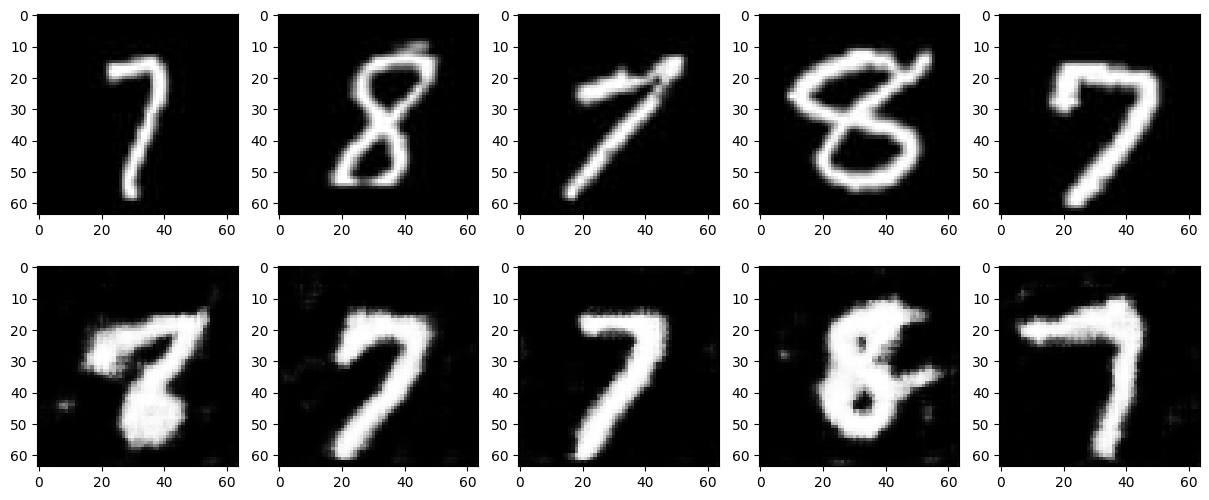

In [73]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')